In [1]:
import torch
import torch.nn as nn
from torch.optim import SGD
import matplotlib.pylab as plt
import numpy as np

In [2]:
class WordDataSet:
    def __init__(self, word):
        self.chars2idx = {}
        self.indexs  = []
        for c in word: 
            if c not in self.chars2idx:
                self.chars2idx[c] = len(self.chars2idx)
            self.indexs.append(self.chars2idx[c])
            
        self.vec_size = len(self.chars2idx)
        self.seq_len  = len(word)
        
    def get_one_hot(self, idx):
        x = torch.zeros(self.vec_size)
        x[idx] = 1
        return x
    
    def __iter__(self):
        return zip(self.indexs[:-1], self.indexs[1:])
    
    def __len__(self):
        return self.seq_len
    
    def get_char_by_id(self, id):
        for c, i in self.chars2idx.items():
            if id == i: return c
        return None

In [3]:
def train_network(net, ds, epochs=100, clip_grad=True):
    full_loss = []
    for epoch in range(epochs):
        args = net.initial()
        loss = 0
        optim.zero_grad()
        for sample, next_sample in ds:
            x = ds.get_one_hot(sample).unsqueeze(0)
            target =  torch.LongTensor([next_sample])
            y, *args = net(x, *args)
            loss += criterion(y, target)
        loss.backward()
        full_loss.append(loss)
        
        if epoch % 10 == 0:
            print ('Loss: ', loss.data.item())
            if clip_grad: print('Clip gradient: ', torch.nn.utils.clip_grad_norm_(net.parameters(), max_norm=5))
        else: 
            if clip_grad: torch.nn.utils.clip_grad_norm_(net.parameters(), max_norm=1)
        
        optim.step()
    return full_loss

In [4]:
def test_network(net, ds, word):
    softmax = nn.Softmax(dim=1)
    net.eval()
    args = net.initial()
    
    id_ = 0
    output = ds.get_char_by_id(id_)
    for _ in word[:-1]:
        x = ds.get_one_hot(id_).unsqueeze(0)
        
        y, *args = net(x, *args)
        y = softmax(y)
        
        m, id_ = torch.max(y, 1)
        id_ = id_.data[0]
        output += ds.get_char_by_id(id_)
    
    print ('Prediction:\t' , output)
    print("Original:\t", word)
    assert(output == word)

## Vanilla RNN
$ h_t = \tanh⁡ (W_{xh} x_t+ W_{hh} h_{t−1}) $  
$ y_t = W_{hy} h_t $

In [5]:
# Простое тестовое слово
simple_word = 'hello'

In [6]:
class VanillaRNN(nn.Module):
    def __init__(self, in_size=5, hidden_size=3, out_size=5):
        super(VanillaRNN, self).__init__()
        self.hidden_size = hidden_size
        self.Wxh = nn.Linear(in_features=in_size, out_features=hidden_size)
        self.Whh = nn.Linear(in_features=hidden_size, out_features=hidden_size)
        self.Why = nn.Linear(in_features=hidden_size, out_features=out_size)
        self.tanh = nn.Tanh()
    
    def forward(self, x, prev_hidden):
        h = self.tanh(self.Wxh(x) + self.Whh(prev_hidden))
        output = self.Why(h)
        return output, h
    
    def initial(self):
        return (torch.zeros(self.hidden_size),)

### Инициализация переменных 

In [7]:
dataset = WordDataSet(simple_word)
vanilla_net = VanillaRNN(in_size=dataset.vec_size, hidden_size=3, out_size=dataset.vec_size)
criterion = nn.CrossEntropyLoss()
optim = SGD(vanilla_net.parameters(), lr = 0.1, momentum=0.9)

In [8]:
loss_history = train_network(vanilla_net, dataset)

Loss:  5.3621368408203125
Clip gradient:  2.265845789247495
Loss:  2.1965692043304443
Clip gradient:  0.6393433539746788
Loss:  0.769859790802002
Clip gradient:  1.3480317840548823
Loss:  0.11998987197875977
Clip gradient:  0.19407112835129425
Loss:  0.03390073776245117
Clip gradient:  0.04462391998827445
Loss:  0.017752647399902344
Clip gradient:  0.017561234568875303
Loss:  0.0129547119140625
Clip gradient:  0.01363793241120897
Loss:  0.01076364517211914
Clip gradient:  0.011126756249104912
Loss:  0.009472370147705078
Clip gradient:  0.008783586480969502
Loss:  0.008614063262939453
Clip gradient:  0.007992125975812604


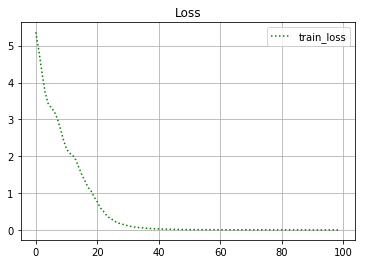

In [9]:
plt.grid(True)
plt.title('Loss')
plt.plot(loss_history, 'g:', label = 'train_loss')
plt.legend()

In [10]:
test_network(vanilla_net, dataset, simple_word)

Prediction:	 hello
Original:	 hello


# ДЗ
Реализовать LSTM и GRU модули, обучить их предсказывать тестовое слово

In [11]:
# Тестовое слово
test_word = 'ololoasdasddqweqw123456789'

## LSTM

$ f_t = \sigma⁡ (W_{xf} x_t + W_{hf} h_{t−1} + b_{f}) $ - *forget gate*  
$ i_t = \sigma⁡ (W_{xi} x_t + W_{hi} h_{t−1} + b_{i}) $ - *input gate*  
$ g_t = \tanh⁡ (W_{xg} x_t + W_{hg} h_{t−1} + b_{g}) $ - *gate gate*  
$ o_t = \sigma⁡ (W_{xo} x_t + W_{ho} h_{t−1} + b_{o}) $ - *output gate*  
$ c_t = f_t \odot c_{t-1} + i_t \odot g_t $ - *cell state*   
$ h_t = o_t \odot \tanh (c_t) $ - *block output*  
$ y_t = W_{hy} h_t $

In [12]:
class LSTM(nn.Module):
    def __init__(self, in_size=5, hidden_size=3, out_size=5):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.Wxf = nn.Linear(in_features=in_size, out_features=hidden_size)
        self.Whf = nn.Linear(in_features=hidden_size, out_features=hidden_size, bias=True)
        self.Wxi = nn.Linear(in_features=in_size, out_features=hidden_size)
        self.Whi = nn.Linear(in_features=hidden_size, out_features=hidden_size, bias=True)
        self.Wxg = nn.Linear(in_features=in_size, out_features=hidden_size)
        self.Whg = nn.Linear(in_features=hidden_size, out_features=hidden_size, bias=True)
        self.Wxo = nn.Linear(in_features=in_size, out_features=hidden_size)
        self.Who = nn.Linear(in_features=hidden_size, out_features=hidden_size, bias=True)
        
        self.tanh = nn.Tanh()
        self.sigm = nn.Sigmoid()
        
        self.Why = nn.Linear(in_features=hidden_size, out_features=out_size)
    
    def forward(self, x, prev_hidden, prev_g):
        f = self.sigm(self.Wxf(x) + self.Whf(prev_hidden))
        i = self.sigm(self.Wxi(x) + self.Whi(prev_hidden))
        g = self.tanh(self.Wxg(x) + self.Whg(prev_hidden))
        o = self.sigm(self.Wxo(x) + self.Who(prev_hidden))
        
        g = f * prev_g + i * g
        hidden = o * self.tanh(g)
        
        output = self.Why(hidden)
        return output, hidden, g
    
    def initial(self):
        return (torch.zeros(self.hidden_size), torch.zeros(self.hidden_size))


In [13]:
dataset = WordDataSet(test_word)
lstm_net = LSTM(in_size=dataset.vec_size, hidden_size=10, out_size=dataset.vec_size)
criterion = nn.CrossEntropyLoss()
optim = SGD(lstm_net.parameters(), lr = 0.1, momentum=0.9)

In [14]:
loss_history = train_network(lstm_net, dataset, 200)

Loss:  70.98298645019531
Clip gradient:  3.2058063768796226
Loss:  62.80668258666992
Clip gradient:  4.786433909169999
Loss:  38.784786224365234
Clip gradient:  8.159660477028098
Loss:  33.72956085205078
Clip gradient:  13.566227584473586
Loss:  28.885501861572266
Clip gradient:  29.641674756735252
Loss:  24.130508422851562
Clip gradient:  29.594746524871454
Loss:  13.709362030029297
Clip gradient:  5.830116637538924
Loss:  8.31236457824707
Clip gradient:  7.4686383506079705
Loss:  4.276544094085693
Clip gradient:  3.41266287810801
Loss:  1.8467445373535156
Clip gradient:  1.750796783306488
Loss:  0.6034727096557617
Clip gradient:  0.3913752056367196
Loss:  0.2565784454345703
Clip gradient:  0.12592831552427786
Loss:  0.15266895294189453
Clip gradient:  0.07212444483269985
Loss:  0.11044120788574219
Clip gradient:  0.04438419202088581
Loss:  0.08944129943847656
Clip gradient:  0.03534583982430419
Loss:  0.07649040222167969
Clip gradient:  0.029783455132729335
Loss:  0.06749153137207031

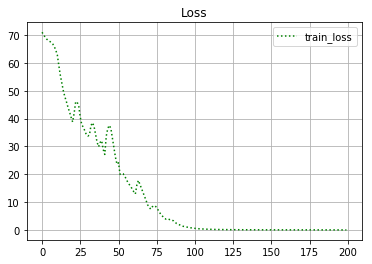

In [15]:
plt.grid(True)
plt.title('Loss')
plt.plot(loss_history, 'g:', label = 'train_loss')
plt.legend()

In [16]:
test_network(lstm_net, dataset, test_word)

Prediction:	 ololoasdasddqweqw123456789
Original:	 ololoasdasddqweqw123456789


## GRU   
$ u_t = \sigma⁡ (W_{xu} x_t + W_{hu} h_{t−1} + b_{u}) $  
$ r_t = \sigma⁡ (W_{xr} x_t + W_{hr} h_{t−1} + b_{r}) $  
$ h'_t = \tanh⁡ (W_{xh'} x_t + W_{hh'} (r_t \odot h_{t-1} )) $  
$ h_t = (1 - u_t) \odot h'_t + u_t \odot h_{t-1} $  
$ y_t = W_{hy} h_t $

In [17]:
class GRU(nn.Module):
    def __init__(self, in_size=5, hidden_size=3, out_size=5):
        super(GRU, self).__init__()
        self.hidden_size = hidden_size
        self.Wxu = nn.Linear(in_features=in_size, out_features=hidden_size)
        self.Whu = nn.Linear(in_features=hidden_size, out_features=hidden_size, bias=True)
        self.Wxr = nn.Linear(in_features=in_size, out_features=hidden_size)
        self.Whr = nn.Linear(in_features=hidden_size, out_features=hidden_size, bias=True)
        self.Wxh = nn.Linear(in_features=in_size, out_features=hidden_size)
        self.Whh = nn.Linear(in_features=hidden_size, out_features=hidden_size, bias=True)
        self.Why = nn.Linear(in_features=hidden_size, out_features=out_size)
        self.tanh = nn.Tanh()
        self.sigm = nn.Sigmoid()
    
    def forward(self, x, prev_hidden):
        u = self.sigm(self.Wxu(x) + self.Whu(prev_hidden))
        r = self.sigm(self.Wxr(x) + self.Whr(prev_hidden))
        candidate_h = self.tanh(self.Wxh(x) + self.Whh(r * prev_hidden))
        h = (torch.ones_like(u) - u) * candidate_h + u * prev_hidden
        
        output = self.Why(h)
        return output, h
    
    def initial(self):
        return (torch.zeros(self.hidden_size),)


In [18]:
dataset = WordDataSet(test_word)
gru_net = GRU(in_size=dataset.vec_size, hidden_size=10, out_size=dataset.vec_size)
criterion = nn.CrossEntropyLoss()
optim = SGD(gru_net.parameters(), lr = 0.1, momentum=0.9)

In [19]:
loss_history = train_network(gru_net, dataset)

Loss:  70.7381591796875
Clip gradient:  4.713367277392281
Loss:  56.71260070800781
Clip gradient:  7.2259390217781325
Loss:  39.135704040527344
Clip gradient:  14.31458116568745
Loss:  23.7965145111084
Clip gradient:  9.617222173786272
Loss:  11.239694595336914
Clip gradient:  3.979727431830835
Loss:  5.007103443145752
Clip gradient:  1.7037074420805796
Loss:  2.0927624702453613
Clip gradient:  1.64305883764484
Loss:  0.4212675094604492
Clip gradient:  0.5122676749633359
Loss:  0.12691688537597656
Clip gradient:  0.10437640800598358
Loss:  0.07083415985107422
Clip gradient:  0.05658281552115217


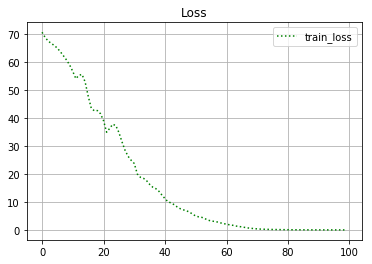

In [20]:
plt.grid(True)
plt.title('Loss')
plt.plot(loss_history, 'g:', label = 'train_loss')
plt.legend()

In [21]:
test_network(gru_net, dataset, test_word)

Prediction:	 ololoasdasddqweqw123456789
Original:	 ololoasdasddqweqw123456789
